In [158]:
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import pickle
import sys

from glob import glob
import random
random.seed(12345)
random_seed = 12345


import librosa
import librosa.display

from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

import scipy as sp
import pandas as pd

### Load and preprocess data functions

In [4]:
def isolate_impact(audioData):
    startIndex = 0
    endIndex = audioData.shape[0]

    for i in range(endIndex):
        if np.abs(audioData[i]) > 0.025: 
            startIndex = i - 200
            if startIndex < 0:
                 startIndex = 0
            endIndex = startIndex + 1024
            break

    # print(startIndex, endIndex)
    return audioData[startIndex:endIndex]

def extract_mfcc(file_path, num_features=13):
    y, sr = librosa.load(file_path)
    y = isolate_impact(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_features)
    return np.mean(mfcc, axis=1)

def extract_fft(file_path, num_features=1024):
    y, sr = librosa.load(file_path)
    y = isolate_impact(y)
    fft, t, ssx = sp.signal.spectrogram(x=y, fs=sr, nperseg=32, return_onesided=True)
    return np.mean(ssx, axis=1)


## Plotting functions

In [159]:

def printSamplesPerClass(y_test):
    classes = ['gravel', 'concrete', 'leaves', 'snow', 'sand', 'grass']
    samples_per_class = {'gravel': 0,
                        'concrete': 0,
                        'leaves': 0,
                        'snow': 0,
                        'sand': 0,
                        'grass': 0,}
    for el in y_test:
        samples_per_class[classes[int(el)]] += 1

    print(samples_per_class)

def plotConfusionMatrix(y_test, y_pred, saveFig=False, name=""):
    classes = ['gravel', 'concrete', 'leaves', 'snow', 'sand', 'grass']
    # Compute the confusion matrix
    # cm = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize="true")
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

    # Visualize the confusion matrix
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)

    # Add labels to axes
    plt.ylabel('Predictions')
    plt.xlabel('Ground Truth')

    if saveFig:
        plt.savefig("figure/audio/" + name + ".svg")
        plt.savefig("figure/audio/" + name + ".png")
    # Show plot
    plt.show()



### Naive approach using vector distance and using MFCC

In [125]:
audio_path = (f'E:/Bruker/Dokumenter/Skole/Master/smart_paws/data/machined/sound/')
classes = ['gravel', 'concrete', 'leaves', 'snow', 'sand', 'grass']
feature_size = 13

X = np.empty((0, feature_size))
y = np.empty((0,))

# Loop through the classes and read the files
for i, class_name in enumerate(classes):
    class_path = os.path.join(audio_path, class_name)
    for file_name in os.listdir(class_path):
        file_path = os.path.join(class_path, file_name)
        
        features = extract_mfcc(file_path, feature_size)
        # Append the features and target to the feature matrix and target vector
        X = np.vstack((X, features))
        y = np.hstack((y, i)).astype(np.int32)


c:\Users\aleks\miniconda3\envs\SmartPaw\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1024
  return f(*args, **kwargs)


[0.6956521739130435, 0.7111111111111111, 0.7111111111111111, 0.7111111111111111, 0.5777777777777777]
0.681 accuracy with a standard deviation of 0.052
Mean accuracy: 0.681352657004831 	min: 0.5777777777777777, idx: 4 	max: 0.7111111111111111, idx: 1
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         8
           1       0.80      1.00      0.89        12
           2       0.50      0.44      0.47         9
           3       0.89      0.80      0.84        10
           4       0.60      0.27      0.37        11
           5       0.30      0.43      0.35         7

    accuracy                           0.63        57
   macro avg       0.61      0.62      0.60        57
weighted avg       0.64      0.63      0.62        57

Test accuracy: 0.632


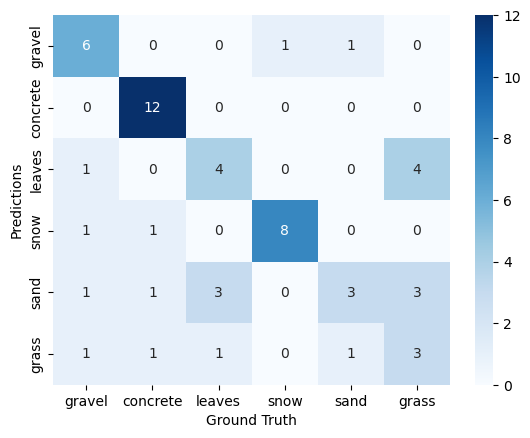

1009


In [276]:
predictions_val = []
correct_labels_val = []
accuracies = []
templates = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=random_seed)


kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state=random_seed)

for train_indicies, test_indicies in kf.split(X_train, y_train):
    # Create Template
    template = {}
    for train_idx in train_indicies:
            if classes[y_train[train_idx]] not in template:
                template[classes[y_train[train_idx]]] = []
            template[classes[y_train[train_idx]]].append(X_train[train_idx])
    for label in classes:
        template[label] = np.mean(template[label], axis=0)
    templates.append(template)

    # Classify the validation data
    prediction_val = []
    correct_label_val = []

    for test_idx in test_indicies:
        minDistance = float('inf')
        bestMatch = None
        for label in classes:
            distance = np.linalg.norm(X_train[test_idx] - template[label])
            if distance < minDistance:
                minDistance = distance
                best_match = classes.index(label)

        prediction_val.append(best_match)
        correct_label_val.append(y_train[test_idx])

    accuracies.append(accuracy_score(correct_label_val, prediction_val))
    # print(classification_report(correct_label_val,prediction_val))


print(accuracies)
print("%0.3f accuracy with a standard deviation of %0.3f" % (np.mean(accuracies), np.std(accuracies)))
print(f'Mean accuracy: {np.mean(accuracies)} \tmin: {min(accuracies)}, idx: {accuracies.index(min(accuracies))} \tmax: {max(accuracies)}, idx: {accuracies.index(max(accuracies))}')
template_accuracies = accuracies


# Find the test data score
prediction_val = []
correct_label_val = []

template = templates[accuracies.index(max(accuracies))]

for x_val, y_val in zip(X_test, y_test):
    minDistance = float('inf')
    bestMatch = None
    y_val = int(y_val)
    for label in classes:
        distance = np.linalg.norm(x_val - template[label])
        if distance < minDistance:
            minDistance = distance
            best_match = label


    prediction_val.append(classes.index(best_match))
    correct_label_val.append(y_val)
template_best = accuracy_score(correct_label_val, prediction_val)
print(classification_report(correct_label_val,prediction_val))
print("Test accuracy: %0.3f" % accuracy_score(correct_label_val, prediction_val))
plotConfusionMatrix(correct_label_val, prediction_val, saveFig=False, name="confusionMatrixTM")

p = pickle.dumps(template)
template_size = sys.getsizeof(p)
print(sys.getsizeof(p))



### Naive approach using vector distance and using FFT

In [8]:

audio_path = (f'E:/Bruker/Dokumenter/Skole/Master/smart_paws/data/machined/sound/')
classes = ['gravel', 'concrete', 'leaves', 'snow', 'sand', 'grass']
feature_size = 17

X_fft = np.empty((0, feature_size))
y_fft = np.empty((0,))

# Loop through the classes and read the files
for i, class_name in enumerate(classes):
    class_path = os.path.join(audio_path, class_name)
    for file_name in os.listdir(class_path):
        file_path = os.path.join(class_path, file_name)
        
        features = extract_fft(file_path, feature_size)
        # print(len(features))
        # Append the features and target to the feature matrix and target vector
        X_fft = np.vstack((X_fft, features))
        y_fft = np.hstack((y_fft, i)).astype(np.int32)



[0.2826086956521739, 0.4, 0.37777777777777777, 0.4222222222222222, 0.35555555555555557]
0.37 accuracy with a standard deviation of 0.05
Mean accuracy: 0.3676328502415459 	min: 0.2826086956521739, idx: 0 	max: 0.4222222222222222, idx: 3
Test accuracy: 0.333
              precision    recall  f1-score   support

      gravel       0.33      0.12      0.18         8
    concrete       0.42      0.42      0.42        12
      leaves       0.17      0.11      0.13         9
        snow       0.50      0.20      0.29        10
        sand       0.36      0.91      0.51        11
       grass       0.00      0.00      0.00         7

    accuracy                           0.33        57
   macro avg       0.30      0.29      0.26        57
weighted avg       0.32      0.33      0.28        57



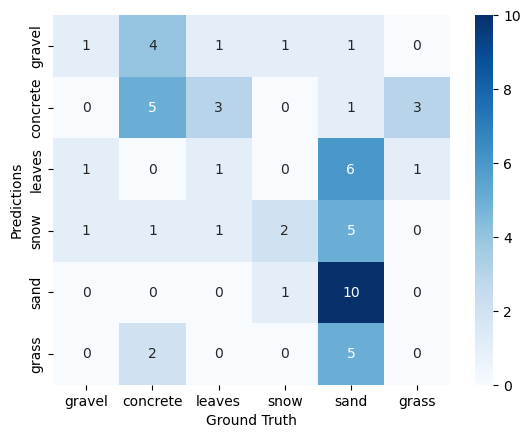

In [9]:
predictions_val = []
correct_labels_val = []
accuracies = []
templates = []

X_train, X_test, y_train, y_test = train_test_split(X_fft, y_fft, test_size = 0.20, random_state=random_seed)


kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state=random_seed)

for train_indicies, test_indicies in kf.split(X_train, y_train):
    # Create Template
    template = {}
    for train_idx in train_indicies:
            if classes[y_train[train_idx]] not in template:
                template[classes[y_train[train_idx]]] = []
            template[classes[y_train[train_idx]]].append(X_train[train_idx])
    for label in classes:
        template[label] = np.mean(template[label], axis=0)
    templates.append(template)

    # Classify the validation data
    prediction_val = []
    correct_label_val = []

    for test_idx in test_indicies:
        minDistance = float('inf')
        bestMatch = None
        for label in classes:
            distance = np.linalg.norm(X_train[test_idx] - template[label])
            if distance < minDistance:
                minDistance = distance
                best_match = classes.index(label)

        prediction_val.append(best_match)
        correct_label_val.append(y_train[test_idx])

    accuracies.append(accuracy_score(correct_label_val, prediction_val))
    # print(classification_report(correct_label_val,prediction_val))

print(accuracies)
print("%0.2f accuracy with a standard deviation of %0.2f" % (np.mean(accuracies), np.std(accuracies)))
print(f'Mean accuracy: {np.mean(accuracies)} \tmin: {min(accuracies)}, idx: {accuracies.index(min(accuracies))} \tmax: {max(accuracies)}, idx: {accuracies.index(max(accuracies))}')


# Find the test data score
prediction_val = []
correct_label_val = []

template = templates[accuracies.index(max(accuracies))]
for x_val, y_val in zip(X_test, y_test):
    minDistance = float('inf')
    bestMatch = None
    y_val = int(y_val)
    for label in classes:
        distance = np.linalg.norm(x_val - template[label])
        if distance < minDistance:
            minDistance = distance
            best_match = label


    prediction_val.append(classes.index(best_match))
    correct_label_val.append(y_val)

print("Test accuracy: %0.3f" % accuracy_score(correct_label_val, prediction_val))
print(classification_report(correct_label_val,
                            prediction_val,
                            target_names = classes))
plotConfusionMatrix(correct_label_val, prediction_val)

### SVM approach using MFCC

In [10]:
# audio_path = (f'E:/Bruker/Dokumenter/Skole/Master/smart_paws/data/machined/sound/')
# classes = ['gravel', 'concrete', 'leaves', 'snow', 'sand', 'grass']
# # Initialize the feature matrix and target vector
# feature_size = 13

# X = np.empty((0, feature_size))
# y = np.empty((0,))

# # Loop through the classes and read the files
# for i, class_name in enumerate(classes):
#     class_path = os.path.join(audio_path, class_name)
#     for file_name in os.listdir(class_path):
#         file_path = os.path.join(class_path, file_name)
#         # Extract the features from the file using librosa or other libraries
#         features = extract_mfcc(file_path, feature_size)
#         # Append the features and target to the feature matrix and target vector
#         X = np.vstack((X, features))
#         y = np.hstack((y, i))

In [271]:
i = 0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify=y, random_state=(random_seed + i))
param_grid = {'C': [10, 1, 0.1, 0.01, 0.001], 'gamma': [0.01,0.001, 1e-4, 1e-5],'kernel': ['rbf', 'poly', 'sigmoid']}
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state=random_seed)

grid = GridSearchCV(svm.SVC(),param_grid=param_grid, refit=True, verbose=1, cv=kf.split(X_train,y_train), n_jobs=5)
grid.fit(X_train,y_train)
# print(grid.best_estimator_)
# grid_predictions = grid.best_estimator_.predict(X_test)
# cross_score = cross_val_score(grid.best_estimator_, X_test, y_test, cv=kf)
# print(cross_score)
# print("%0.3f accuracy with a standard deviation of %0.3f" % (cross_score.mean(), cross_score.std()))
# plotConfusionMatrix(y_test, grid_predictions)
# print("Accuracy score: %0.3f" %accuracy_score(y_test, grid_predictions))
# print(classification_report(y_test,
#                             grid_predictions,
#                             target_names = classes))


Fitting 5 folds for each of 60 candidates, totalling 300 fits
[[-3.26901642e+02  1.51533554e+02  2.11740589e+01 ...  1.51609688e+01
  -5.91887093e+00  6.05354118e+00]
 [-2.71884186e+02  1.54270248e+02  1.12170668e+01 ...  2.28277283e+01
  -1.06715689e+01  4.45576143e+00]
 [-3.04641113e+02  1.76700394e+02  2.45330200e+01 ...  2.02370338e+01
  -9.85780048e+00  5.35951281e+00]
 ...
 [-2.81286499e+02  1.48529770e+02  3.21389809e+01 ...  1.71766682e+01
  -1.52820177e+01 -6.07505500e-01]
 [-4.24825439e+02  1.52765335e+02  4.27180214e+01 ...  1.02377539e+01
  -4.74655581e+00  3.20140451e-01]
 [-3.08072876e+02  1.37366226e+02  3.08932095e+01 ...  1.84431686e+01
  -1.31053591e+01 -8.07952940e-01]]


In [275]:
np.set_printoptions(threshold=sys.maxsize)
print(grid.best_estimator_.__dict__)


{'decision_function_shape': 'ovr', 'break_ties': False, 'kernel': 'poly', 'degree': 3, 'gamma': 1e-05, 'coef0': 0.0, 'tol': 0.001, 'C': 10, 'nu': 0.0, 'epsilon': 0.0, 'shrinking': True, 'probability': False, 'cache_size': 200, 'class_weight': None, 'verbose': False, 'max_iter': -1, 'random_state': None, '_sparse': False, 'n_features_in_': 13, 'class_weight_': array([1., 1., 1., 1., 1., 1.]), 'classes_': array([0, 1, 2, 3, 4, 5]), '_gamma': 1e-05, 'support_': array([  8,  22,  23,  32,  40,  53,  63,  68,  72,  74,  82,  90,  93,
       104, 106, 108, 125, 128, 148, 151, 166, 168, 169, 177, 186, 192,
       196, 200, 219,  28,  38,  52,  94, 172, 178,   1,   3,   9,  12,
        20,  24,  29,  44,  49,  58,  71,  95, 105, 111, 113, 116, 117,
       120, 122, 139, 143, 144, 147, 165, 179, 187, 189, 206, 208, 211,
       222,   5,  10,  17,  18,  21,  45,  57,  76,  78,  84,  97, 102,
       114, 121, 123, 131, 140, 153, 154, 163, 171, 185, 218,   6,  11,
        13,  14,  27,  36,  42,  

### K Neighbors classifier MFCC 

The best classifier:  KNeighborsClassifier()
with the score:  0.8007729468599033

[0.66666667 0.58333333 0.54545455 0.72727273 0.63636364]
0.632 accuracy with a standard deviation of 0.063


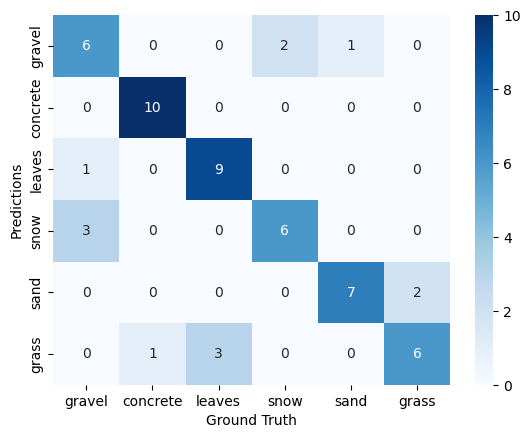

Accuracy score: 0.772
              precision    recall  f1-score   support

      gravel       0.60      0.67      0.63         9
    concrete       0.91      1.00      0.95        10
      leaves       0.75      0.90      0.82        10
        snow       0.75      0.67      0.71         9
        sand       0.88      0.78      0.82         9
       grass       0.75      0.60      0.67        10

    accuracy                           0.77        57
   macro avg       0.77      0.77      0.77        57
weighted avg       0.77      0.77      0.77        57



In [76]:
#create new a knn model
knn = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_grid = GridSearchCV(knn, param_grid, cv=kf)
#fit model to data
knn_grid.fit(X_train,y_train)

print("The best classifier: ", knn_grid.best_estimator_,) 
print("with the score: ", knn_grid.best_score_)
print()
grid_predictions = knn_grid.best_estimator_.predict(X_test)
cross_score = cross_val_score(knn_grid.best_estimator_, X_test, y_test, cv=kf)
print(cross_score)
print("%0.3f accuracy with a standard deviation of %0.3f" % (cross_score.mean(), cross_score.std()))
plotConfusionMatrix(y_test, grid_predictions)
print("Accuracy score: %0.3f" %accuracy_score(y_test, grid_predictions))
print(classification_report(y_test,
                            grid_predictions,
                            target_names = classes))

### Random Foreste Classifier MFCC

The best classifier:  RandomForestClassifier(max_depth=4, n_estimators=9, random_state=12345)
with the score:  0.7567149758454106

[0.75       0.75       0.72727273 0.81818182 0.63636364]
0.736 accuracy with a standard deviation of 0.059


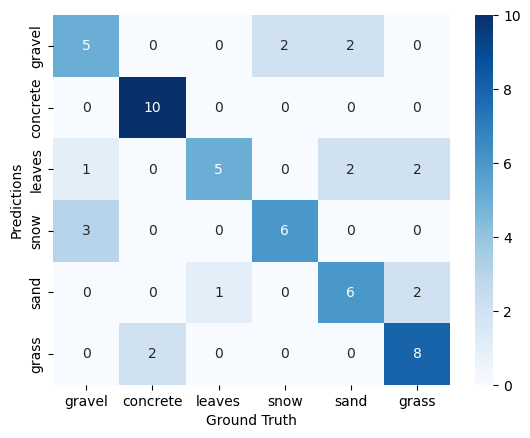

Accuracy score: 0.702
              precision    recall  f1-score   support

      gravel       0.56      0.56      0.56         9
    concrete       0.83      1.00      0.91        10
      leaves       0.83      0.50      0.62        10
        snow       0.75      0.67      0.71         9
        sand       0.60      0.67      0.63         9
       grass       0.67      0.80      0.73        10

    accuracy                           0.70        57
   macro avg       0.71      0.70      0.69        57
weighted avg       0.71      0.70      0.70        57

28555
[0.15287539 0.14189429 0.10920428 0.19932577 0.06718564 0.02188583
 0.04087127 0.09388471 0.00900219 0.05357848 0.02548943 0.06659454
 0.01820818]


In [77]:
#create new a rfc model
rfc = RandomForestClassifier(random_state=random_seed)
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'max_depth': np.arange(1, 5), 'n_estimators': np.arange(1,10)},
#use gridsearch to test all values for n_neighbors
rfc_grid = GridSearchCV(rfc, param_grid, cv=kf)
#fit model to data
rfc_grid.fit(X_train,y_train)

print("The best classifier: ", rfc_grid.best_estimator_,) 
print("with the score: ", rfc_grid.best_score_)
print()
grid_predictions = rfc_grid.best_estimator_.predict(X_test)
cross_score = cross_val_score(rfc_grid.best_estimator_, X_test, y_test, cv=kf)
print(cross_score)
print("%0.3f accuracy with a standard deviation of %0.3f" % (cross_score.mean(), cross_score.std()))
plotConfusionMatrix(y_test, grid_predictions)
print("Accuracy score: %0.3f" %accuracy_score(y_test, grid_predictions))
print(classification_report(y_test,
                            grid_predictions,
                            target_names = classes))

import pickle
import sys

p = pickle.dumps(rfc_grid.best_estimator_)
print(sys.getsizeof(p))
importances = rfc_grid.best_estimator_.feature_importances_
print(importances)


### Ada Boost Classifier MFCC

The best classifier:  AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2),
                   n_estimators=83, random_state=12345)
with the score:  0.8054106280193236

[0.75       0.66666667 0.81818182 0.45454545 0.63636364]
0.665 accuracy with a standard deviation of 0.123


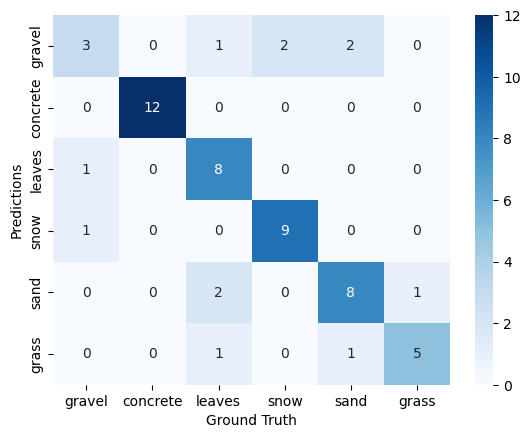

Accuracy score: 0.789
              precision    recall  f1-score   support

      gravel       0.60      0.38      0.46         8
    concrete       1.00      1.00      1.00        12
      leaves       0.67      0.89      0.76         9
        snow       0.82      0.90      0.86        10
        sand       0.73      0.73      0.73        11
       grass       0.83      0.71      0.77         7

    accuracy                           0.79        57
   macro avg       0.77      0.77      0.76        57
weighted avg       0.79      0.79      0.78        57



In [279]:
#create new a ada model

ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), random_state=random_seed, algorithm="SAMME")
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_estimators': np.arange(1,  300)}
#use gridsearch to test all values for n_neighbors
ada_grid = GridSearchCV(ada, param_grid, cv=kf)
#fit model to data
ada_grid.fit(X_train,y_train)

print("The best classifier: ", ada_grid.best_estimator_,) 
print("with the score: ", ada_grid.best_score_)
print()
grid_predictions = ada_grid.best_estimator_.predict(X_test)
cross_score = cross_val_score(ada_grid.best_estimator_, X_test, y_test, cv=kf)
print(cross_score)
print("%0.3f accuracy with a standard deviation of %0.3f" % (cross_score.mean(), cross_score.std()))
plotConfusionMatrix(y_test, grid_predictions)
print("Accuracy score: %0.3f" %accuracy_score(y_test, grid_predictions))
print(classification_report(y_test,
                            grid_predictions,
                            target_names = classes))


### Decision Tree Classifier MFCC

The best classifier:  DecisionTreeClassifier(max_depth=5, random_state=12345)
with the score:  0.672463768115942

[0.66666667 0.66666667 0.54545455 0.54545455 0.81818182]
0.648 accuracy with a standard deviation of 0.101


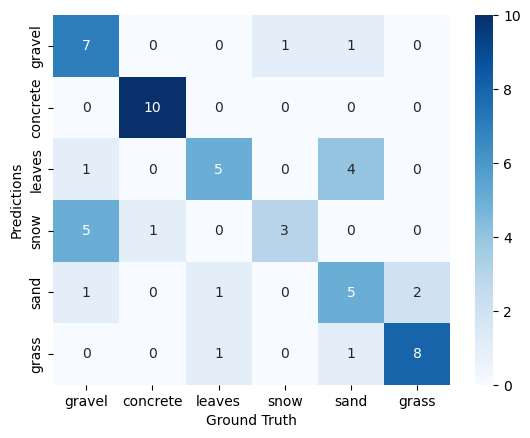

Accuracy score: 0.667
              precision    recall  f1-score   support

      gravel       0.50      0.78      0.61         9
    concrete       0.91      1.00      0.95        10
      leaves       0.71      0.50      0.59        10
        snow       0.75      0.33      0.46         9
        sand       0.45      0.56      0.50         9
       grass       0.80      0.80      0.80        10

    accuracy                           0.67        57
   macro avg       0.69      0.66      0.65        57
weighted avg       0.69      0.67      0.66        57

4967
[0.14865091 0.20035774 0.02359547 0.31840938 0.13384911 0.
 0.02952229 0.06279388 0.         0.         0.02134876 0.03346237
 0.02801009]


In [79]:
#create new a ada model
dtc = DecisionTreeClassifier(random_state=random_seed)


#create a dictionary of all values we want to test for n_neighbors
param_grid = {'max_depth': np.arange(1,  10)}
#use gridsearch to test all values for n_neighbors
dtc_grid = GridSearchCV(dtc, param_grid, cv=kf)
#fit model to data
dtc_grid.fit(X_train,y_train)

print("The best classifier: ", dtc_grid.best_estimator_,) 
print("with the score: ", dtc_grid.best_score_)
print()
grid_predictions = dtc_grid.best_estimator_.predict(X_test)
cross_score = cross_val_score(dtc_grid.best_estimator_, X_test, y_test, cv=kf)
print(cross_score)
print("%0.3f accuracy with a standard deviation of %0.3f" % (cross_score.mean(), cross_score.std()))
plotConfusionMatrix(y_test, grid_predictions)
print("Accuracy score: %0.3f" %accuracy_score(y_test, grid_predictions))
print(classification_report(y_test,
                            grid_predictions,
                            target_names = classes))


p = pickle.dumps(dtc_grid.best_estimator_)
print(sys.getsizeof(p))
importances = dtc_grid.best_estimator_.feature_importances_
print(importances)

### Naive Bayes MFCC

The best classifier:  GaussianNB()
with the score:  0.8142995169082126

[0.83333333 0.66666667 0.90909091 0.54545455 0.72727273]
0.736 accuracy with a standard deviation of 0.127


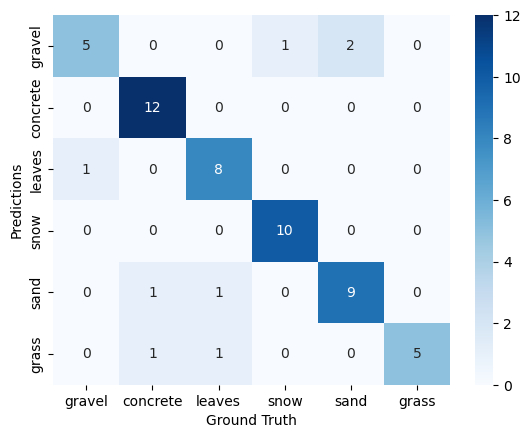

Accuracy score: 0.860
              precision    recall  f1-score   support

      gravel       0.83      0.62      0.71         8
    concrete       0.86      1.00      0.92        12
      leaves       0.80      0.89      0.84         9
        snow       0.91      1.00      0.95        10
        sand       0.82      0.82      0.82        11
       grass       1.00      0.71      0.83         7

    accuracy                           0.86        57
   macro avg       0.87      0.84      0.85        57
weighted avg       0.86      0.86      0.85        57

1936


In [257]:
#create new a ada model
gnb = GaussianNB()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {}
#use gridsearch to test all values for n_neighbors
gnb_grid = GridSearchCV(gnb, param_grid, cv=kf)
#fit model to data
gnb_grid.fit(X_train,y_train)

print("The best classifier: ", gnb_grid.best_estimator_,) 
print("with the score: ", gnb_grid.best_score_)
print()
grid_predictions = gnb_grid.best_estimator_.predict(X_test)
cross_score = cross_val_score(gnb_grid.best_estimator_, X_test, y_test, cv=kf)
print(cross_score)
print("%0.3f accuracy with a standard deviation of %0.3f" % (cross_score.mean(), cross_score.std()))
plotConfusionMatrix(y_test, grid_predictions, saveFig=False, name="confusionMatrixNB")
# plt.savefig("figure/audio/confusionMatrixNB.svg")
print("Accuracy score: %0.3f" %accuracy_score(y_test, grid_predictions))
print(classification_report(y_test,
                            grid_predictions,
                            target_names = classes))


p = pickle.dumps(gnb_grid.best_estimator_)
print(sys.getsizeof(p))
# print(gnb_grid.best_estimator_.__dict__)

### QDA MFCC

The best classifier:  QuadraticDiscriminantAnalysis()
with the score:  0.7658937198067632

[0.25       0.16666667 0.09090909 0.27272727 0.36363636]
0.229 accuracy with a standard deviation of 0.093


c:\Users\aleks\miniconda3\envs\SmartPaw\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\aleks\miniconda3\envs\SmartPaw\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\aleks\miniconda3\envs\SmartPaw\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\aleks\miniconda3\envs\SmartPaw\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\aleks\miniconda3\envs\SmartPaw\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


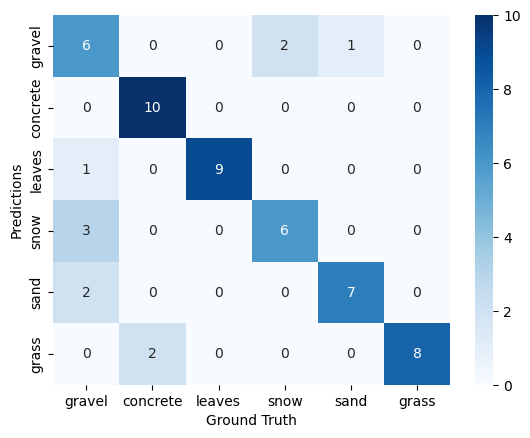

Accuracy score: 0.807
              precision    recall  f1-score   support

      gravel       0.50      0.67      0.57         9
    concrete       0.83      1.00      0.91        10
      leaves       1.00      0.90      0.95        10
        snow       0.75      0.67      0.71         9
        sand       0.88      0.78      0.82         9
       grass       1.00      0.80      0.89        10

    accuracy                           0.81        57
   macro avg       0.83      0.80      0.81        57
weighted avg       0.83      0.81      0.81        57

10350


In [83]:
#create new a ada model
qda = QuadraticDiscriminantAnalysis()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {}
#use gridsearch to test all values for n_neighbors
qda_grid = GridSearchCV(qda, param_grid, cv=kf)
#fit model to data
qda_grid.fit(X_train,y_train)

print("The best classifier: ", qda_grid.best_estimator_,) 
print("with the score: ", qda_grid.best_score_)
print()
grid_predictions = qda_grid.best_estimator_.predict(X_test)
cross_score = cross_val_score(qda_grid.best_estimator_, X_test, y_test, cv=kf)
print(cross_score)
print("%0.3f accuracy with a standard deviation of %0.3f" % (cross_score.mean(), cross_score.std()))
plotConfusionMatrix(y_test, grid_predictions)
print("Accuracy score: %0.3f" %accuracy_score(y_test, grid_predictions))
print(classification_report(y_test,
                            grid_predictions,
                            target_names = classes))


p = pickle.dumps(qda_grid.best_estimator_)
print(sys.getsizeof(p))

# Trying with a DNN

In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.run_functions_eagerly(True)

In [ ]:

# Define the DNN architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu', input_shape=(feature_size,)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])


lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    0.01, decay_steps=25, decay_rate=0.98, staircase=True
)



# Compile the model

model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])
print(model.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 8)                 112       
                                                                 
 dense_43 (Dense)            (None, 8)                 72        
                                                                 
 dense_44 (Dense)            (None, 6)                 54        
                                                                 
Total params: 238
Trainable params: 238
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
accuracies = []

# Perform stratified k-fold cross-validation
for train_indices, test_indices in kf.split(X_train, y_train):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(8, activation='relu', input_shape=(feature_size,)),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(len(classes), activation='softmax')
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

    # Train the model on the training data
    model.fit(X_train[train_indices], y_train[train_indices], epochs=50, verbose=0)
    
    # Evaluate the model on the validation data
    _, y_pred = model.evaluate(X_train[test_indices], y_train[test_indices])
    # accuracy = accuracy_score(y_train[test_indices], y_pred)
    accuracies.append(y_pred)

# Print the cross-validation results
print("Cross-Validation Accuracy: {:.3f} +/- {:.3f}".format(np.mean(accuracies), np.std(accuracies)))


c:\Users\aleks\miniconda3\envs\SmartPaw\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2/2 [==============================] - 0s 14ms/step - loss: 1.0933 - accuracy: 0.8000
Cross-Validation Accuracy: 0.779 +/- 0.039


In [ ]:
dnn_accuracies = accuracies
# Train the final model on the full training data
# model.fit(X_train, y_train, epochs=100, verbose=1)
model.save(f'saved_model/audio_DNN16_16')


INFO:tensorflow:Assets written to: saved_model/audio_DNN16_16\assets


2/2 [==============================] - 0s 4ms/step


c:\Users\aleks\miniconda3\envs\SmartPaw\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


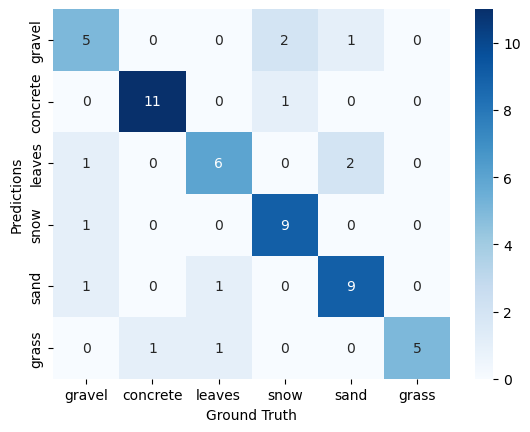

In [ ]:
model = keras.models.load_model(f'saved_model/audio_DNN16_16')

model.evaluate(X_test, y_test)

y_prediction = model.predict(X_test)
y_prediction = np.argmax (y_prediction, axis = 1)
#Create confusion matrix and normalizes it over predicted (columns)
plotConfusionMatrix(y_test, y_prediction, saveFig=False, name="confusionMatrixDNN")

# result = confusion_matrix(y_test, y_prediction , normalize='pred')

### Comparison of the different models

In [293]:
names = [
    "SVM",
    "Nearest Neighbors",
    "Random Forest",
    "AdaBoost",
    "Decision Tree",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    svm.SVC(),
    KNeighborsClassifier(),
    RandomForestClassifier(random_state=random_seed),
    AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), random_state=random_seed, algorithm="SAMME"),
    DecisionTreeClassifier(random_state=random_seed),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]





param_grids = [
    {'C': [10, 1, 0.1, 0.01, 0.001], 'gamma': [0.01,0.001, 1e-4, 1e-5],'kernel': ['rbf', 'poly', 'sigmoid']},
    {'n_neighbors': np.arange(1, 10)}, 
    {'max_depth': np.arange(1, 5), 'n_estimators': np.arange(1,30)},
    {'n_estimators': np.arange(80,  85)},
    {'max_depth': np.arange(1,  10)},
    {},
    {},
]

data = []


for i in range(len(classifiers)):
    grid = GridSearchCV(classifiers[i], param_grids[i], cv=kf)

    grid.fit(X_train,y_train)

    
    print(f'Testing {names[i]}')
    p = pickle.dumps(grid.best_estimator_)
    size = sys.getsizeof(p)
    print("Model size: %0.0f Bytes" % sys.getsizeof(p))
    # print(f'Best: {grid.best_estimator_} with score: {grid.best_score_:.3f}')

    grid_predictions = grid.best_estimator_.predict(X_test)
    cross_score = cross_val_score(grid.best_estimator_, X_test, y_test, cv=kf)
    accuracy = accuracy_score(y_test, grid_predictions)
    # print(cross_score)
    print("%0.3f accuracy with a standard deviation of %0.3f" % (cross_score.mean(), cross_score.std()))
    print("Accuracy score on test data: %0.3f" % accuracy)
# plotConfusionMatrix(y_test, grid_predictions)
    # print(classification_report(y_test,
    #                             grid_predictions,
    #                             target_names = classes))

    data.append({'Name': names[i], 
                'Model': grid.best_estimator_ , 
                'Size': size, 
                'Cross Score Mean': cross_score.mean(), 
                'Cross Score Std': cross_score.std(), 
                'Accuracy': accuracy})


    print()
    print()


data.append({'Name': 'Template Matching', 
            'Model': '', 
            'Size': 1009, 
            'Cross Score Mean': 0.681352657004831, 
            'Cross Score Std': 0.05213238640824659, 
            'Accuracy': 0.632})

data.append({'Name': 'DNN 16-16', 
            'Model': '', 
            'Size': (3128), 
            'Cross Score Mean': 0.7788405895233155, 
            'Cross Score Std': 0.03921134276878212, 
            'Accuracy': 0.789})
df = pd.DataFrame(data)

print(df)

Testing SVM
Model size: 17527 Bytes
0.718 accuracy with a standard deviation of 0.106
Accuracy score on test data: 0.842


Testing Nearest Neighbors
Model size: 29108 Bytes
0.629 accuracy with a standard deviation of 0.112
Accuracy score on test data: 0.772


Testing Random Forest
Model size: 74490 Bytes
0.667 accuracy with a standard deviation of 0.088
Accuracy score on test data: 0.789


Testing AdaBoost
Model size: 88229 Bytes
0.665 accuracy with a standard deviation of 0.123
Accuracy score on test data: 0.789


Testing Decision Tree
Model size: 7463 Bytes
0.486 accuracy with a standard deviation of 0.200
Accuracy score on test data: 0.737


Testing Naive Bayes
Model size: 1936 Bytes
0.736 accuracy with a standard deviation of 0.127
Accuracy score on test data: 0.860


Testing QDA
Model size: 10350 Bytes
0.314 accuracy with a standard deviation of 0.094
Accuracy score on test data: 0.807


                Name                                              Model  \
0                SV

c:\Users\aleks\miniconda3\envs\SmartPaw\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\aleks\miniconda3\envs\SmartPaw\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\aleks\miniconda3\envs\SmartPaw\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\aleks\miniconda3\envs\SmartPaw\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\aleks\miniconda3\envs\SmartPaw\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [295]:
df.to_csv("audioClassificationResults.csv", index = False)

In [296]:
df = pd.read_csv("audioClassificationResults.csv")
print(df)

                Name                                              Model  \
0                SVM            SVC(C=0.1, gamma=0.0001, kernel='poly')   
1  Nearest Neighbors                KNeighborsClassifier(n_neighbors=7)   
2      Random Forest  RandomForestClassifier(max_depth=4, n_estimato...   
3           AdaBoost  AdaBoostClassifier(algorithm='SAMME',\n       ...   
4      Decision Tree  DecisionTreeClassifier(max_depth=7, random_sta...   
5        Naive Bayes                                       GaussianNB()   
6                QDA                    QuadraticDiscriminantAnalysis()   
7  Template Matching                                                NaN   
8          DNN 16-16                                                NaN   

    Size  Cross Score Mean  Cross Score Std  Accuracy  
0  17527          0.718182         0.105670  0.842105  
1  29108          0.628788         0.112367  0.771930  
2  74490          0.666667         0.087827  0.789474  
3  88229          0.66515

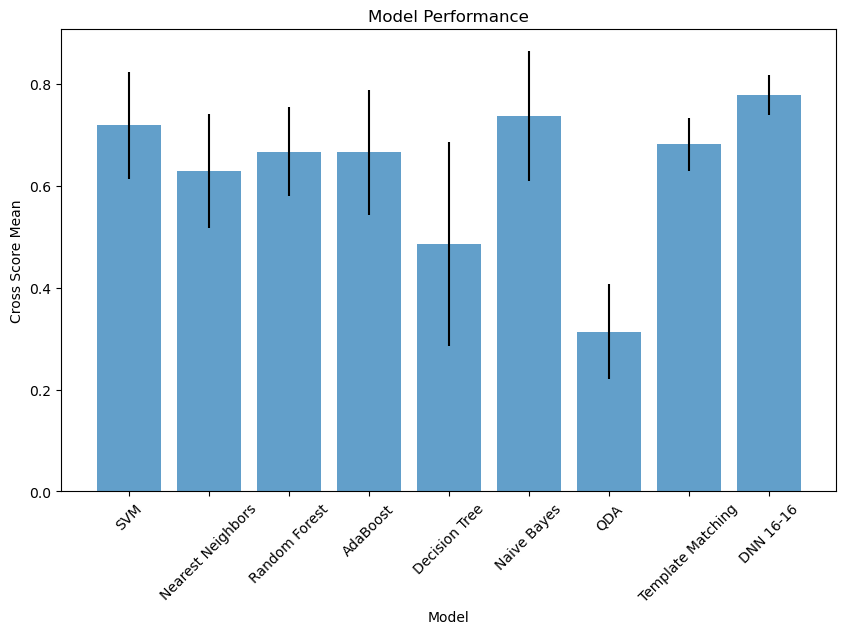

In [297]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the bar chart
plt.bar(df['Name'], df['Cross Score Mean'], yerr=df['Cross Score Std'], alpha=0.7)

# Set the x-axis label
plt.xlabel('Model')

# Set the y-axis label
plt.ylabel('Cross Score Mean')

# Set the plot title
plt.title('Model Performance')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Display the plot
plt.savefig('figure/audio/crossvalHist.svg')
plt.show()


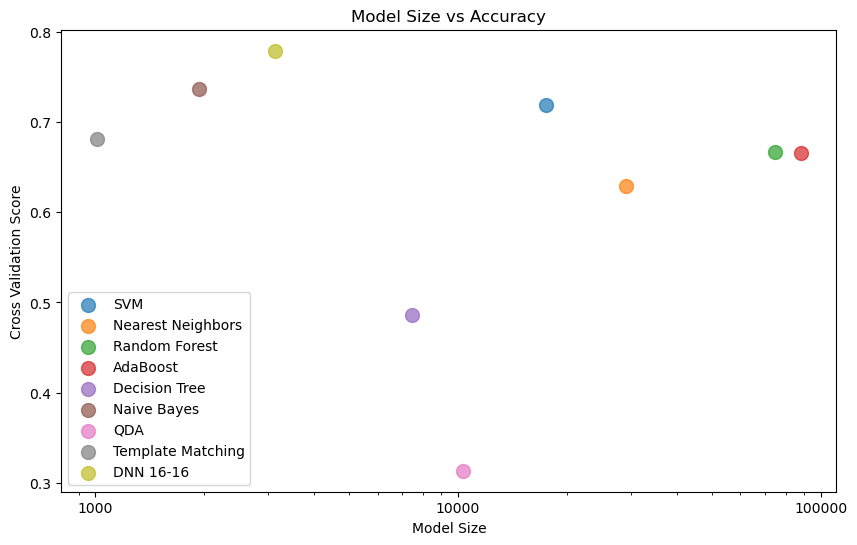

In [298]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Define the colors for each model
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']

# Create the scatter plot
for i, row in df.iterrows():
    plt.scatter(row['Size'], row['Cross Score Mean'], s=100, c=colors[i], alpha=0.7, label=row['Name'])

# Set the x-axis label
plt.xlabel('Model Size')
plt.semilogx()
# Set the starting point of the x-axis at 1000
plt.xticks(ticks=[1000, 10000, 100000], labels=[1000, 10000, 100000])
# Set the y-axis label
plt.ylabel('Cross Validation Score')

# Set the plot title
plt.title('Model Size vs Accuracy')

# Add a legend
plt.legend()

# Display the plot
plt.savefig('figure/audio/sizeVsAccuracyScatter.svg')
plt.show()

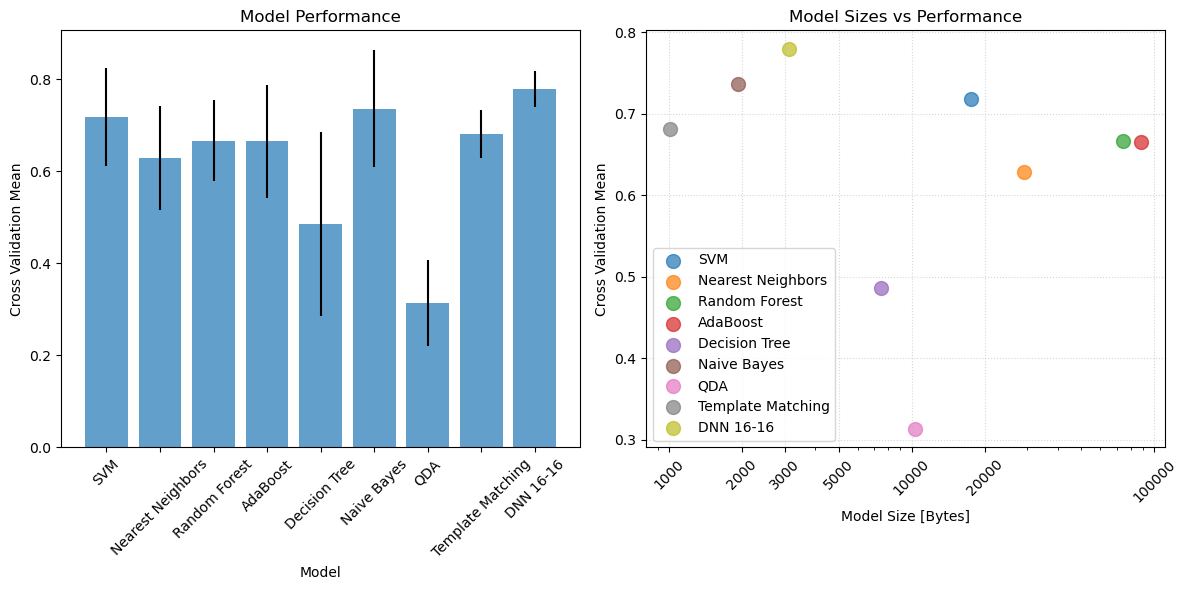

In [299]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Accuracy
axs[0].bar(df['Name'], df['Cross Score Mean'], yerr=df['Cross Score Std'], alpha=0.7)
axs[0].set_xlabel('Model')
axs[0].set_ylabel('Cross Validation Mean')
axs[0].set_title('Model Performance')

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']


# Plot 2: Model Sizes
for i, row in df.iterrows():
    axs[1].scatter(row['Size'], row['Cross Score Mean'], s=100, c=colors[i], alpha=0.7, label=row['Name'])
    axs[1].set_xscale('log')  # Set x-axis scale to semi-log
    axs[1].set_xticks([1000, 2000, 3000, 5000, 10000, 20000, 100000])  # Set the tick locations on x-axis
    axs[1].set_xticklabels([1000, 2000, 3000, 5000, 10000, 20000, 100000])  # Set the tick labels on x-axis
    axs[1].legend()

# Add weak grid lines
axs[1].grid(True, linestyle=':', alpha=0.5)

axs[1].set_ylabel('Cross Validation Mean')
axs[1].set_xlabel('Model Size [Bytes]')
axs[1].set_title('Model Sizes vs Performance')

# Rotate the x-axis labels in the first subplot for better visibility
axs[0].tick_params(axis='x', rotation=45)
axs[1].tick_params(axis='x', rotation=45)
# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.savefig('figure/audio/performanceAndSize.svg')
plt.show()